In [77]:
from convexness.convexness import *
import glob
import os
import open3d as o3d
import pandas as pd
from tqdm import tqdm

In [93]:
n_random_samples = 800
min_fragments = 3
max_fragments = 8
num_points = 100000

In [94]:
def process_our_folder(folder, dataset_index):
    target_extension = '.stl'
    metadata_pattern = '*_mesh.txt'
    path = folder + '*/' + metadata_pattern
    mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)
    
    #
    global_df = None
    
    for metadata_file in mesh_files:
        df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
        
        # maintain only a subset of the columns
        df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
        if global_df is None:
            global_df = df
        else:
            global_df = pd.concat([global_df, df], ignore_index=True)
            
    # filter files by target extension
    global_df = global_df[global_df['Filename'].str.contains(target_extension)]
            
    # create a new column with the number of fragments
    global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))
    # select n random samples
    global_df = global_df[max_fragments >= global_df['Fragments']]  
    global_df = global_df[min_fragments <= global_df['Fragments']]
    
    print('Number of fragments:', global_df.shape[0])
    
    global_df = global_df.sample(n=n_random_samples)

    # iterate to calculate the convexness
    for index, row in tqdm(global_df.iterrows(), total=global_df.shape[0]):
        filename = row['Filename']
        filename = filename.replace('E:/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl/')
        if dataset_index == 1:
            filename = filename.replace('C:/Github/MeshFragments/MeshFragments/Assets/Models/Artifacts/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_2/')
        elif dataset_index == 2:
            filename = filename.replace('C:/Github/MeshFragments/MeshFragments/Assets/Models/Artifacts/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_3/')
        
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    return global_df

In [95]:
def process_voronoi_folder(folder):
    target_extension = '.obj'
    files = glob.glob(folder + '*/*' + target_extension, recursive=True)
    # get number of fragments as the first number in the filename before '_'
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    for file in files:
        file_name = os.path.basename(file)
        fragments = int(file_name.split('_')[0])
        global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [fragments]})], ignore_index=True)
        
    # filter by the number of fragments
    global_df = global_df[max_fragments >= global_df['Fragments']]
    global_df = global_df[min_fragments <= global_df['Fragments']] 
    
    # random sampling
    print('Number of fragments:', global_df.shape[0])
    random_rows = global_df.sample(n=n_random_samples)
    for index, row in tqdm(random_rows.iterrows()):
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [96]:
def process_sellan_folder(folder):
    # find subfolders
    subfolders = glob.glob(folder + '*/*/')
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    
    for subfolder in subfolders:
        # find obj inside the subfolder
        files = glob.glob(subfolder + '*.obj')
        n_fragments = len(files)
        
        if min_fragments<= n_fragments <= max_fragments:          
            for file in files:
                global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [n_fragments]})], ignore_index=True)
            
    print('Number of fragments:', global_df.shape[0])
            
    # read the mesh
    random_rows = global_df.sample(n=n_random_samples)
    for index, row in tqdm(random_rows.iterrows()):
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [ ]:
#folders = ['D:/allopezr/Fragments/Vessels_200_Voronoi/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/']

folders = ['D:/allopezr/Fragments/Artifacts_200_CellFracture/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_2/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_3/', 'D:/allopezr/Datasets/BreakingBad/artifact/']

#folders = ['D:/allopezr/Datasets/BreakingBad/artifact_compressed/']
results = []

for index, folder in tqdm(enumerate(folders)):
    print(folder)
    
    if 'CellFracture' in folder:
        global_df = process_voronoi_folder(folder)
    elif 'BreakingBad' in folder:
        global_df = process_sellan_folder(folder)
    else:
        global_df = process_our_folder(folder, index - 1) 
        
    results.append(global_df[['Fragments', 'Convexness']])

0it [00:00, ?it/s]

D:/allopezr/Fragments/Artifacts_200_CellFracture/
Number of fragments: 812



0it [00:00, ?it/s]
1it [00:00,  1.23it/s]
2it [00:01,  1.02it/s]
3it [00:03,  1.15s/it]
4it [00:04,  1.01s/it]
5it [00:04,  1.05it/s]
6it [00:05,  1.10it/s]
7it [00:07,  1.03s/it]
8it [00:07,  1.01s/it]
9it [00:08,  1.06it/s]
10it [00:09,  1.05it/s]
11it [00:10,  1.01s/it]
12it [00:11,  1.02s/it]
13it [00:12,  1.02s/it]
14it [00:13,  1.08it/s]
15it [00:14,  1.12it/s]
16it [00:15,  1.10it/s]
17it [00:16,  1.07it/s]
18it [00:17,  1.11s/it]
19it [00:18,  1.07s/it]
20it [00:19,  1.06it/s]
21it [00:20,  1.08it/s]
22it [00:21,  1.07s/it]
23it [00:22,  1.02it/s]
24it [00:23,  1.04s/it]
25it [00:25,  1.16s/it]
26it [00:26,  1.16s/it]
27it [00:27,  1.17s/it]
28it [00:28,  1.15s/it]
29it [00:29,  1.18s/it]
30it [00:31,  1.28s/it]
31it [00:32,  1.25s/it]
32it [00:33,  1.18s/it]
33it [00:34,  1.09s/it]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(


Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\21\3_21.compressed_mesh_cell.003.obj



35it [00:35,  1.26it/s]
36it [00:36,  1.19it/s]
37it [00:37,  1.14it/s]
38it [00:38,  1.12it/s]
39it [00:39,  1.12it/s]
40it [00:40,  1.11it/s]
41it [00:41,  1.10it/s]
42it [00:41,  1.09it/s]
43it [00:42,  1.17it/s]
44it [00:43,  1.17it/s]
45it [00:44,  1.02s/it]
46it [00:45,  1.02s/it]
47it [00:46,  1.00it/s]
48it [00:47,  1.02s/it]
49it [00:49,  1.06s/it]
50it [00:50,  1.00it/s]
51it [00:50,  1.03it/s]
52it [00:51,  1.00s/it]
53it [00:53,  1.09s/it]
54it [00:54,  1.14s/it]
55it [00:55,  1.15s/it]
56it [00:56,  1.15s/it]
57it [00:57,  1.08s/it]
58it [00:58,  1.08s/it]
59it [00:59,  1.01it/s]

In [ ]:
results_copy = results.copy()

In [ ]:
# calculate only for sellan
global_df = process_sellan_folder('D:/allopezr/Datasets/BreakingBad/artifact/')

In [ ]:
# substitute this result with the previous one
results[2] = global_df[['Fragments', 'Convexness']]

In [ ]:
import matplotlib.pyplot as plt

# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 19}
plt.rc('font', **font_mapping)

In [ ]:
# render the results
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work (x2 extra seeds)', 'Ours (x1 extra seeds)', 'Ours (no extra seeds)', 'Sellán et al.']

plt.figure(figsize=(8, 5))

# average convexness per number of fragments
for idx, (df, legend) in enumerate(zip(results, legends)):  
    df = df.dropna()
    mean = 1.0 - df.groupby('Fragments').mean()
    std = df.groupby('Fragments').std()  
    
    print(std)
    
    # box plot
    plt.errorbar(mean.index, mean['Convexness'], yerr=std['Convexness'], fmt='o-', label=legend, capsize=10)
    
    # represent as points whose size is proportional to std
    #plt.scatter(mean.index, mean['Convexness'], s=std['Convexness'] * 1000, label=legend)
    
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=3, fontsize=14)
plt.xlabel('Fragments')
plt.ylabel('Convexity')
plt.xlim(3 - 0.14, max_fragments + 0.14)
plt.tight_layout()
plt.savefig('convexness.png', dpi=300)
plt.show()

In [ ]:
# percentil 75, 50, 25
for df in results:
    print(df['Convexness'].quantile([0.25, 0.5, 0.75]))

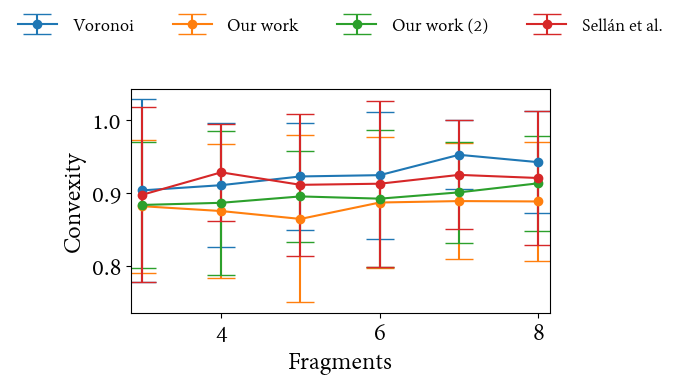

In [71]:
# chart with error bars
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work (x2 extra seeds)', 'Ours (x1 extra seeds)', 'Ours (no extra seeds)', 'Sellán et al.']

global_mean = []
global_std = []

for idx, (df, legend) in enumerate(zip(results, legends)):  
    df = df.dropna()
    mean = 1.0 - df.groupby('Fragments').mean()
    std = df.groupby('Fragments').std()  
    
    global_mean.append(mean)
    global_std.append(std)
    
    # box plot
    plt.errorbar(mean.index, mean['Convexness'], yerr=std['Convexness'], fmt='o-', label=legend, capsize=10)
    
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fontsize=14)
plt.xlabel('Fragments')
plt.ylabel('Convexity')
plt.xlim(3 - 0.14, max_fragments + 0.14)
plt.tight_layout()
plt.savefig('convexness.png', dpi=300)
plt.show()